In [1]:
import torch
import torch.nn as nn
import tiktoken

In [2]:
from gpt_model import *

In [3]:
# to make training faster on a laptop, change context_length as shown:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,         # Embedding dimension 
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate (10% of activation tensor is set to 0, per forward pass)
    "qkv_bias": False       # Query-Key-Value bias
}

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
model = GPTModel(GPT_CONFIG_124M)

In [6]:
start_context = "He was armed with a long bow of yew wood"

In [ ]:
#to give gibberish output just to show its trying

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)



print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 He was armed with a long bow of yew woodoren eloquvisual battleenda oralTal mediation Valve specs


In [15]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["He was armed",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" armed with a",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
with torch.no_grad(): #disables gradient tracking, pytorch builds no graph and no gradient is stored. 
    #used for inference/eval used for running the model not learning
    logits = model(inputs)

probs = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probs.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [13]:
probs

tensor([[[2.7697e-05, 9.0636e-06, 3.1339e-05,  ..., 8.1393e-06,
          9.5565e-06, 2.2934e-05],
         [2.0467e-05, 1.1062e-05, 7.1092e-06,  ..., 7.0050e-06,
          2.8771e-05, 1.2013e-05],
         [2.2424e-05, 6.8287e-06, 1.9796e-05,  ..., 9.0208e-06,
          1.3735e-05, 1.5140e-05]],

        [[1.2894e-05, 1.3995e-05, 4.0670e-05,  ..., 9.9802e-06,
          1.5458e-05, 1.6000e-05],
         [2.2501e-05, 1.0211e-05, 1.1247e-05,  ..., 1.2867e-05,
          1.5972e-05, 1.2637e-05],
         [2.1587e-05, 6.2733e-06, 3.3350e-05,  ..., 1.1212e-05,
          1.7629e-05, 1.3616e-05]]])

In [ ]:
# predicted tokens:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

#picks highest probable token at each position, dim -1 -> across dimension
# keep dim- the shape remains aligned, it stays able to get a token, predict then keep shifting

Token IDs:
 tensor([[[26711],
         [ 6557],
         [46612]],

        [[34487],
         [13791],
         [33070]]])


In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

In [13]:
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 2:  really like chocolate
Outputs batch 2: Pri grey cram


In [14]:
targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [ ]:
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probs_2)

# selecting models predicted probabilities for correct next tokens
# probs = shape(b,seq, vocab), that shape is the same as batch, num_tokens, d_in 
# for each token position, give probability, for each token, give me vector representation 
#  text 
#batch of 2, seq_len = 3, each row = 1 text sample
# #[
#   [t11, t12, t13],
#   [t21, t22, t23]
# ]#


Text 1: tensor([2.1299e-05, 1.7519e-05, 1.5568e-05])
Text 2: tensor([2.0574e-05, 1.8915e-05, 1.0504e-05])


In [16]:
torch.set_printoptions( sci_mode=False )

In [ ]:
# Compute logarithm of all token probabilities
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

#cross entropy calcs

tensor([-10.7568, -10.9522, -11.0703, -10.7915, -10.8755, -11.4638])


In [ ]:
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)
neg_avg_log_probs = avg_log_probs * -1
print(neg_avg_log_probs)



tensor(-10.9850)
tensor(10.9850)


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

# flatten reshapes so cross entropy treats every token prediction as one 
#classification example

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [20]:
print(logits_flat)
print(targets_flat)

tensor([[-0.1166,  0.4131,  0.1192,  ..., -0.9238, -0.4077, -0.2832],
        [ 0.3386, -0.0832,  0.8338,  ..., -0.7654, -0.0748, -0.6247],
        [ 0.3640,  0.0377,  1.0781,  ...,  0.7329, -0.1739, -0.1215],
        [-0.3704,  0.9823,  0.9950,  ..., -0.7827, -0.9639, -0.5060],
        [ 0.4205,  0.6336,  0.2788,  ..., -0.3413, -0.1324, -0.0769],
        [-0.1156,  0.4582,  1.3515,  ...,  0.0808, -0.3733,  0.4753]])
tensor([ 3626,  6100,   345,  1107,   588, 11311])


In [21]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9850)


In [ ]:
# a more interpretable version of cross entropy --
# this is basically the number of tokens the model considers for predicted output
perplexity = torch.exp(loss)
print(perplexity)

# the model is about as sure as we have 59000 possible predicted tokens

tensor(58984.5117)


In [16]:
# use the short story from before for training:
with open( "thelostrace.txt", "r" ) as f:
    text_data = f.read()
print(text_data[:100])

Cororuc glanced about him and hastened his pace. He was no coward, but he did not like the place. Ta


In [17]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [19]:
# separate text into training and validation sets:
# Train/validation ratio


train_ratio = 0.90 # using 90% of the data to train on, 10% to validate or to "check" how the model does
split_idx = int(train_ratio * len(text_data)) # index where you split the data from train to val
train_data = text_data[:split_idx] 
val_data = text_data[split_idx:]

torch.manual_seed(123) #makes results reproducible 

train_loader = create_dataloader_v1(          # build data loader for training
    train_data,                               # training text data
    batch_size=2,                             # 2 sequences per batch
    max_length=GPT_CONFIG_124M["context_length"],  # max tokens per sequence
    stride=GPT_CONFIG_124M["context_length"],      # move window by full length
    drop_last=True,                           # drop incomplete last batch
    shuffle=True,                             # randomize order each epoch
    num_workers=0                             # load data in main process
)

val_loader = create_dataloader_v1(            # build data loader for validation
    val_data,                                 # validation text data
    batch_size=2,                             # 2 sequences per batch
    max_length=GPT_CONFIG_124M["context_length"],  # same context length
    stride=GPT_CONFIG_124M["context_length"],      # same window step
    drop_last=False,                          # keep smaller last batch
    shuffle=False,                            # keep order fixed
    num_workers=0                             # load data in main process
)


In [20]:
train_tokens = 0                              # counter for training tokens
for input_batch, target_batch in train_loader:  # loop over training batches
    train_tokens += input_batch.numel()       # count all tokens in batch

val_tokens = 0                                # counter for validation tokens
for input_batch, target_batch in val_loader:  # loop over validation batches
    val_tokens += input_batch.numel()         # count all tokens in batch

print("Training tokens:", train_tokens)       # show training token count
print("Validation tokens:", val_tokens)       # show validation token count
print("All tokens:", train_tokens + val_tokens)  # show total tokens


Training tokens: 6144
Validation tokens: 512
All tokens: 6656


In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):   # compute loss for one batch
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)  # move to CPU/GPU
    logits = model(input_batch)                                   # forward pass → predictions
    loss = torch.nn.functional.cross_entropy(                     # compute CE loss
        logits.flatten(0, 1),                                      # merge batch + time dims
        target_batch.flatten()                                     # flatten targets to match
    )
    return loss                                                    # return batch loss


def calc_loss_loader(data_loader, model, device, num_batches=None):  # avg loss over loader
    total_loss = 0.                                                 # accumulate loss
    if len(data_loader) == 0:                                       # handle empty loader
        return float("nan")
    elif num_batches is None:                                       # use all batches
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))            # cap batch count
    for i, (input_batch, target_batch) in enumerate(data_loader):   # loop over batches
        if i < num_batches:                                         # stop at limit
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # batch loss
            total_loss += loss.item()                               # add scalar loss
        else:
            break                                                   # exit loop
    return total_loss / num_batches                                  # return mean loss


In [ ]:
if torch.cuda.is_available():                 # check if NVIDIA GPU is available
    device = torch.device("cuda")             # use CUDA GPU
elif torch.backends.mps.is_available():       # check if Apple GPU is available
    major, minor = map(int, torch.__version__.split(".")[:2])  # get PyTorch version
    if (major, minor) >= (2, 9):               # ensure version supports stable MPS
        device = torch.device("mps")           # use Apple GPU
else:
    device = torch.device("cpu")               # fallback to CPU

print(f"Using {device} device.")               # print chosen device


model.to(device)                              # move model to selected device

torch.manual_seed(123)                        # fix randomness for repeatable results

with torch.no_grad():                         # disable gradients (no training)
    train_loss = calc_loss_loader(train_loader, model, device)  # compute train loss
    val_loss = calc_loss_loader(val_loader, model, device)      # compute val loss

print("Training loss:", train_loss)           # print training loss
print("Validation loss:", val_loss)           # print validation loss

"""
**the model isn’t learning anything yet**.

* Train ≈ Val → no overfitting
* Loss = **very high** → predictions are mostly wrong
* Model is near **random guessing**
* Typical causes: untrained weights, tiny dataset, or wrong targets

"""

Using cpu device.
Training loss: 10.98396583557129
Validation loss: 10.992756207784018


In [22]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):  
    # Trains the model and periodically evaluates performance

    train_losses, val_losses, track_tokens_seen = [], [], []  
    # Lists to store loss history and how many tokens the model has seen

    tokens_seen, global_step = 0, -1  
    # Counters for total tokens processed and total optimization steps

    for epoch in range(num_epochs):  
        # Loop over full passes through the training dataset
        model.train()  
        # Enable training behavior (dropout on, etc.)
        
        for input_batch, target_batch in train_loader:  
            # Iterate over batches of tokenized input/target pairs

            optimizer.zero_grad()  
            # Clear gradients from the previous batch

            loss = calc_loss_batch(input_batch, target_batch, model, device)  
            # Forward pass + compute cross-entropy loss for this batch

            loss.backward()  
            # Backpropagate loss to compute gradients for all parameters

            optimizer.step()  
            # Update model weights using the computed gradients

            tokens_seen += input_batch.numel()  
            # Count how many tokens have been processed so far

            global_step += 1  
            # Count how many optimization steps have occurred

            if global_step % eval_freq == 0:  
                # Periodically evaluate model performance
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )  
                # Compute average train/validation loss on a subset of batches

                train_losses.append(train_loss)  
                # Save training loss

                val_losses.append(val_loss)  
                # Save validation loss

                track_tokens_seen.append(tokens_seen)  
                # Track learning progress vs tokens seen

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )  
                # Print progress update

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )  
        # Generate sample text to qualitatively inspect learning progress

    return train_losses, val_losses, track_tokens_seen  
    # Return loss history and token counts


def evaluate_model(model, train_loader, val_loader, device, eval_iter):  
    # Evaluates model loss without updating weights

    model.eval()  
    # Switch to evaluation mode (dropout off)

    with torch.no_grad():  
        # Disable gradient tracking for speed and memory savings
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )  
        # Compute average training loss on limited batches

        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )  
        # Compute average validation loss on limited batches

    model.train()  
    # Switch back to training mode

    return train_loss, val_loss  
    # Return evaluation losses


def generate_and_print_sample(model, tokenizer, device, start_context):  
    # Generates example text from the current model state

    model.eval()  
    # Set model to inference mode

    context_size = model.pos_emb.weight.shape[0]  
    # Get maximum context length from positional embeddings

    encoded = text_to_token_ids(start_context, tokenizer).to(device)  
    # Tokenize the starting text and move it to the device

    with torch.no_grad():  
        # No gradients needed during generation
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )  
        # Autoregressively generate new tokens

    decoded_text = token_ids_to_text(token_ids, tokenizer)  
    # Convert generated token IDs back to readable text

    print(decoded_text.replace("\n", " "))  
    # Print generated text in a compact format

    model.train()  
    # Restore training mode


In [24]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="He was armed", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 9.820, Val loss 9.878
Ep 1 (Step 000005): Train loss 7.966, Val loss 8.324
Ep 1 (Step 000010): Train loss 6.817, Val loss 7.360
He was armed.                                                 
Ep 2 (Step 000015): Train loss 6.083, Val loss 6.991
Ep 2 (Step 000020): Train loss 5.818, Val loss 6.980
He was armed, and, and the                                             
Ep 3 (Step 000025): Train loss 5.512, Val loss 6.871
Ep 3 (Step 000030): Train loss 4.977, Val loss 6.810
Ep 3 (Step 000035): Train loss 4.805, Val loss 6.750
He was armed. The a great a.                                            
Ep 4 (Step 000040): Train loss 4.382, Val loss 6.741
Ep 4 (Step 000045): Train loss 3.884, Val loss 6.724
He was armed, and a great to the forest, and the forest.          " was in the forest, and the forest, and the forest, and the forest, and the forest, and the forest.  
Ep 5 (Step 000050): Train loss 3.710, Val loss 6.709
Ep 5 (Step 000055): Train loss 3.199, Va

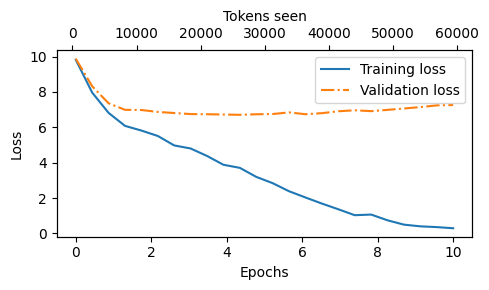

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [26]:
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("He was armed", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 He was armed with a heard burst of savage yells, from back up the trail, and chirping birds, of which he was used


In [28]:
# read the book for more details and examples!
# temperature scaling and top-k sampling together increase 
# the diversity of predictions

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [29]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("He was armed", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 He was armed that far two kings! long that if the and miles it vanish into our
